## Notebook Purpose

Evaluate output of original fastmri (pytorch=1.5) vs new fastmri (pytorch=1.7) to see if output is the same

In [22]:
import os, sys
from os import listdir
from os.path import isfile, join
import numpy as np
import torch
from matplotlib import pyplot as plt

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, normalize_img

In [23]:
def plot_list(arr_list):
    
    NUM_COLS = len(arr_list)
    title_list = ['ground-truth', 'old', 'new']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')
    plt.show()

In [63]:
path_o = '/bmrNAS/people/dvv/out_fastmri/old_pytorch1.5/'
path_n = '/bmrNAS/people/dvv/out_fastmri/new_pytorch1.7/norm_ortho/'

def get_files(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

files_o = [f for f in get_files(path_o) if 'iter10000_alpha0.npy' in f]
files_n_dc = [f for f in get_files(path_n) if '_dc.npy' in f]

In [64]:
files_n_dc

['1000007_dc.npy',
 '1000273_dc.npy',
 '1000325_dc.npy',
 '1000464_dc.npy',
 '1000537_dc.npy',
 '1000818_dc.npy',
 '1001140_dc.npy',
 '1001219_dc.npy',
 '1001338_dc.npy',
 '1001533_dc.npy',
 '1001598_dc.npy',
 '1001798_dc.npy']

### norm none

In [61]:
ssim_n_list.mean(), ssim_o_list.mean()

(0.7301150076006316, 0.7825565964726002)

In [62]:
psnr_n_list.mean(), psnr_o_list.mean()

(31.4297750241296, 31.607801604556304)

### norm ortho

In [66]:
ssim_n_list.mean(), ssim_o_list.mean()

(0.7389274574292739, 0.7825566006348911)

In [67]:
psnr_n_list.mean(), psnr_o_list.mean()

(31.588734934864988, 31.607801684480517)

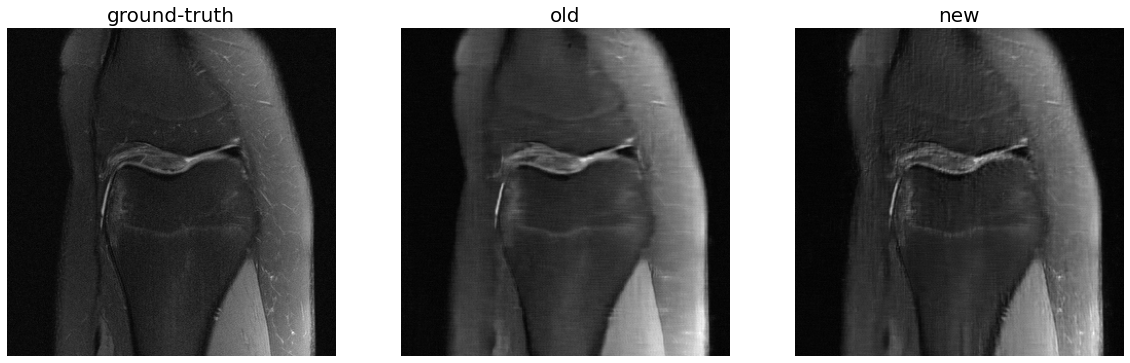

1000273
0.7516028564659959 30.837173954257665
0.7603502066727859 31.526079050724384


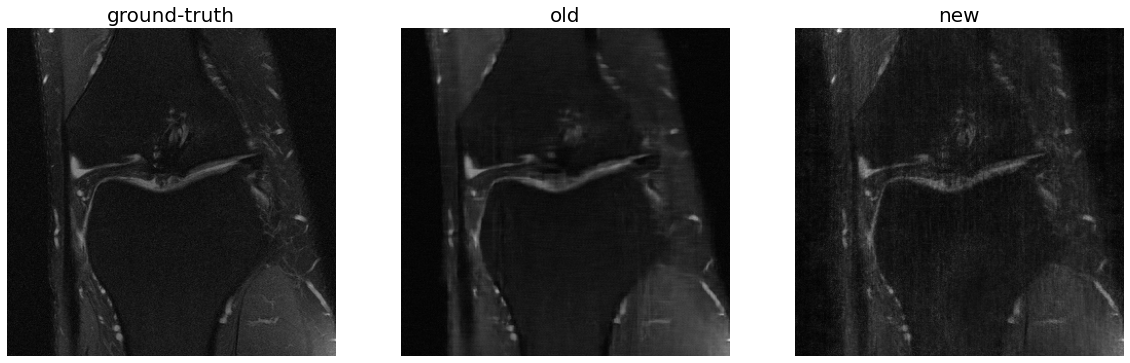

1000325
0.7638936926923392 32.14250682497399
0.6582776857846315 30.27927497164029


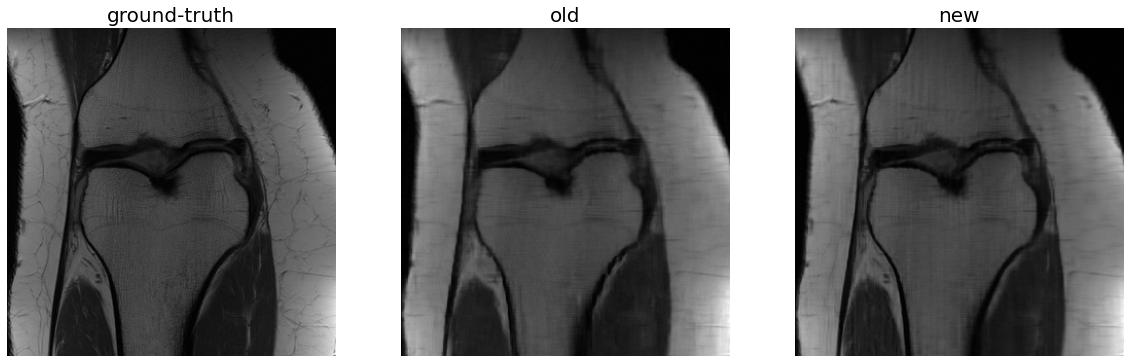

1000464
0.8420059564300316 32.622498328861205
0.8709488812249172 34.6582691779493


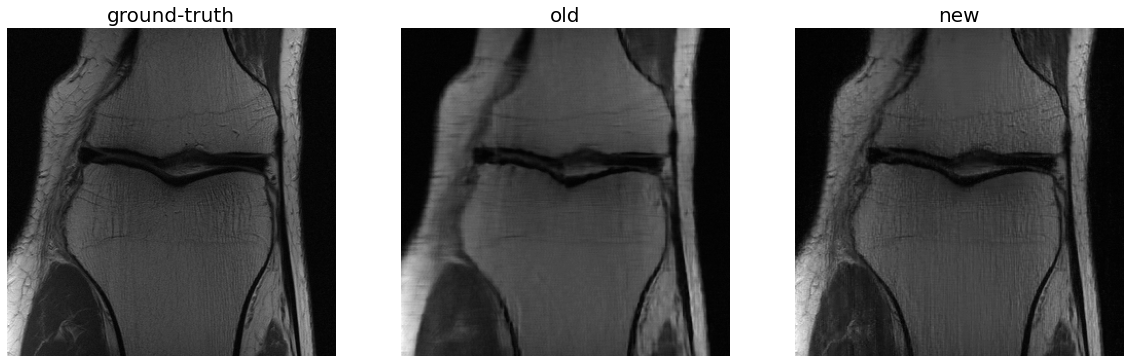

1000537
0.797108998684401 30.98192990388204
0.8246742740956695 32.92192389599956


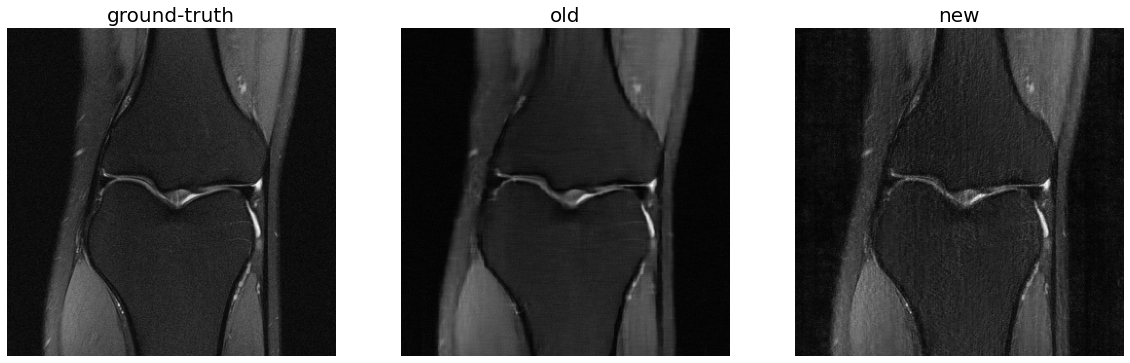

1000818
0.7875588336795045 32.069665854851095
0.6627600498044031 30.215795067284773


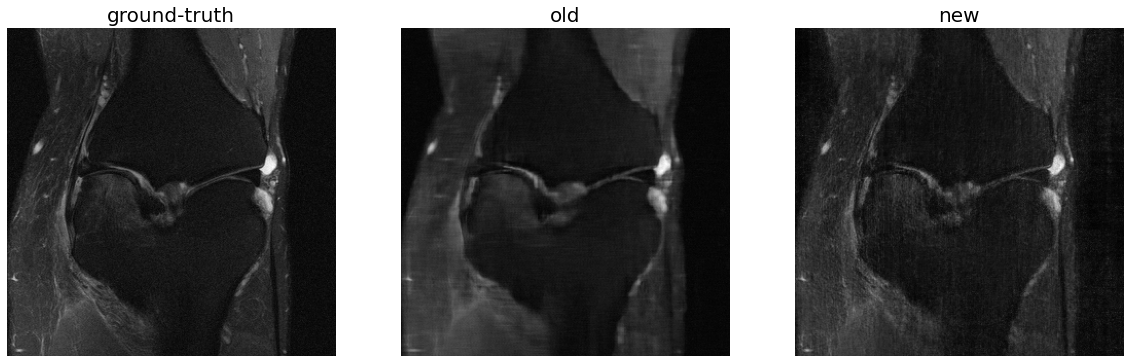

1001140
0.753169265857074 30.993035240057097
0.6565536469932362 29.931067445591637


In [65]:
ssim_n_list, ssim_o_list = [], []
psnr_n_list, psnr_o_list = [], []

for f in files_n_dc[1:7]:
    
    vid_key = f.split('_')[0]
    
    arr_n = np.load(path_n + f)
    arr_o = np.load('{}{}_iter10000_alpha0.npy'.format(path_o, vid_key))
    arr_gt = np.load('{}{}_gt.npy'.format(path_n, vid_key))
    
    plot_list([arr_gt, arr_o, arr_n])
    
    _, _, ssim_n, psnr_n = calc_metrics(arr_n, arr_gt)
    _, _, ssim_o, psnr_o = calc_metrics(arr_o, arr_gt)
    ssim_n_list.append(ssim_n), psnr_n_list.append(psnr_n)
    ssim_o_list.append(ssim_o), psnr_o_list.append(psnr_o)
    
    print(vid_key)
    print(ssim_o, psnr_o)
    print(ssim_n, psnr_n)
    
ssim_n_list = np.asarray(ssim_n_list)
ssim_o_list = np.asarray(ssim_o_list)
psnr_n_list = np.asarray(psnr_n_list)
psnr_o_list = np.asarray(psnr_o_list)